In [1]:
import torch
import matplotlib.pyplot as plt
from dataloader import MRIDataset
from residual3dunet.model import ResidualUNet3D
from torch.utils.data import Dataset, DataLoader
from utils import dice_coefficient, iou, plotloss, plotaccuracy, compute_average, add_mask_colour
import torchvision.transforms as T
import nibabel as nib
import numpy as np

<Figure size 432x288 with 0 Axes>

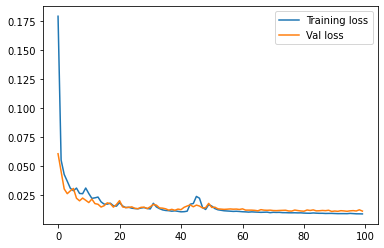

<Figure size 432x288 with 0 Axes>

In [59]:
plotloss('output/train17.out')
plt.figure()
# plotaccuracy('output/train6.out')


In [3]:
device = torch.device('cpu')
model = ResidualUNet3D(in_channels=1, out_channels=1, testing=True).to(device)

# model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load("model/model4.pt", map_location=device))

<All keys matched successfully>

In [4]:
testdataset = MRIDataset(train=False, transform=T.ToTensor())
test_loader = DataLoader(dataset = testdataset, batch_size=1, shuffle=False)

print(len(test_loader))

image_path = './dataset/train/T1/MRI1_T1.nii.gz'
image_obj = nib.load(image_path)

# Extract data as numpy array
image_data = image_obj.get_fdata()

image_data = np.pad(image_data, ((0,0),(0,0),(0,1)))
image_data = np.moveaxis(image_data, 2, 0)
image_data = np.moveaxis(image_data, 2, 1)
image_data = torch.from_numpy(image_data)
image_data = torch.unsqueeze(image_data, 0)
image_data = torch.unsqueeze(image_data, 0)
# print(image_data.shape)

50


In [72]:
model.eval()

dataiter = iter(test_loader)
data = dataiter.next()
# data = dataiter.next()
# data = dataiter.next()
features, labels = data

features, labels = features.float().to(device), labels.float().to(device)

# image_data = image_data.float().to(device)

# output = model(features)

In [15]:
def iou(pred, target):

    pred = pred.int()
    target = target.int()

    intersection = (pred & target).float().sum((1,2))
    union = (pred | target).float().sum((1,2))

    iou = (intersection + 1e-6) / (union + 1e-6)

    return iou.mean()


def dice_coefficient(pred, target):

    dice_score = 0
    dice_score += (2 * (pred * target).sum()) / (
                (pred + target).sum() + 1e-8
            )

    return dice_score

def jaccard(prediction, truth):
    return np.sum(prediction[truth==1]) / (np.sum(prediction[truth==1]) + np.sum(prediction!=truth))

def dice(prediction, truth):
        return np.sum(prediction[truth==1]) * 2.0 / (np.sum(prediction) + np.sum(truth))

In [64]:
# preds = torch.sigmoid(output)
preds = (output > 0.5).float()

# print(preds.shape)
# print(labels.shape)
batch, channel, depth, width, height = preds.shape

print(iou(preds, labels))
print(dice_coefficient(preds, labels))


AttributeError: 'numpy.ndarray' object has no attribute 'int'

In [8]:
preds = preds.numpy()
labels = labels.numpy()
preds = preds.astype(bool)
labels = labels.astype(bool)

print(jaccard(preds[0,0,:,:,:], labels[0,0,:,:,:]))
print(dice(preds[0,0,:,:,:], labels[0,0,:,:,:]))

0.8632333928461491
0.9265971682994928


In [ ]:
# Visualize Single Image Data
f, axarr = plt.subplots(14,3,figsize=(50,50))

for i in range(depth):
    axarr[i,0].imshow(image_data[0,0,i,:,:],cmap='gray')
    axarr[i,1].imshow(preds[0,0,i,:,:],cmap='gray')
    axarr[i,2].imshow(labels[0,0,i,:,:],cmap='gray')
    plt.axis('off')

In [ ]:
from segmentation_statistics import SegmentationStatistics

preds = preds.numpy()
labels = labels.numpy()
preds = preds.astype(bool)
labels = labels.astype(bool)

# preds = preds.bool()
# labels = labels.bool()

stat = SegmentationStatistics(preds[0,0,:,:,:], labels[0,0,:,:,:], (3,2,1))

In [ ]:

# preds = preds.numpy()
# labels = labels.numpy()

# preds = np.squeeze(preds, 0)
# labels = np.squeeze(labels, 0)

# predmask = preds.astype(bool)
# labelmask = labels.astype(bool)

# preds[predmask] = 255
# labels[labelmask] = 255

# preds = np.pad(preds, ((0,2),(0,0),(0,0),(0,0)))
# labels = np.pad(labels, ((2,0),(0,0),(0,0),(0,0)))

# preds = np.moveaxis(preds, 0, 2)
# labels = np.moveaxis(labels, 0, 2)

# preds = preds.astype(np.uint8)
# labels = labels.astype(np.uint8)

# print(preds.shape)
# print(labels.shape)

# for i in range(14):
#     plt.imshow(preds[:,:,:,i])
#     plt.axis('off')
#     plt.show()


In [76]:
from ipywidgets import interact
from PIL import ImageEnhance

# overlap = labels + preds
labels = add_mask_colour(labels, "blue")

print(labels.shape)

def explore_3d_image(layer):
    
    plt.figure(figsize=(5,5))
    # plt.imshow(features[layer,:,:],cmap='gray')
    plt.imshow(labels[layer,:,:,:])
    plt.title('Explore Segmented MRI')
    plt.axis('off')
    return layer

interact(explore_3d_image, layer=(0,labels.shape[0]-1))

(14, 240, 240, 3)


interactive(children=(IntSlider(value=6, description='layer', max=13), Output()), _dom_classes=('widget-intera…

<function __main__.explore_3d_image(layer)>